<a href="https://colab.research.google.com/github/FernandaSzAdr/CNN_cromossome/blob/master/TesteRede2_Binaria_Base2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [2]:
!pip install imutils

import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.optimizers import SGD
from keras.layers.core import Dense, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from keras.callbacks import ModelCheckpoint

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score

from skimage import transform

import cv2
import csv
import imutils
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os

Using TensorFlow backend.


## Funções

In [0]:
def converte(regiao):
   regiao = np.array(regiao).astype('float32')/255
   regiao = transform.resize(regiao, (120, 120, 3))
   regiao = np.expand_dims(regiao, axis=0)
   return regiao


In [0]:
def ler_images_teste(arquiteture):
  y_true = []
  y_predict = []
  prob = []
  
  images_test = os.listdir(test_path)
  local = 'drive/My Drive/Resultado/Segmentado/Resultado_Image/' + arquiteture
  if os.path.isdir(local) == False:
    os.mkdir(local)
  
  for img in images_test:
    # Pega cada imagem separadamente do folder de teste
    image = cv2.imread(test_path + '/' + img)
    f = open('drive/My Drive/Base_CNN/Binarizado2/posicoes_segmentada.csv', 'r')
    
    copia = image.copy()

    try:
      leitor = csv.reader(f)
      leitor = list(leitor)
      leitor.pop(0)
      for linha in leitor:
        if len(linha) > 0:
          # Para cada região dessa imagem:
          if linha[0] == img:
            posicoes = []
            x = int(linha[3])
            y = int(linha[4])
            w = int(linha[5])
            h = int(linha[6])
            
            # Label da região
            label = linha[1]
            if label == 'NC':
              y_true.append(0)
            else:
              y_true.append(1)
            
            # Região
            regiao = image[y: y + h, x: x + w]
            regiao = converte(regiao)
            
            # Coloca a região na função e obtem o resultado
            predicao = model.predict(regiao,batch_size=bSize,verbose=0)
           
            # Probabilidade de ser da classe 1
            prob.append(predicao[0][1])
            
            # Se é um cromossomo:
            if predicao[0][1] > predicao[0][0]:
              y_predict.append(1)
              cv2.rectangle(copia,(x, y),(x+w, y+h),(0,255,0), 1)
            # Se não for um cromossomo:
            else:
              y_predict.append(0)
              cv2.rectangle(copia,(x, y),(x+w, y+h),(0,0,255), 1)
                        
    finally:
      f.close()
    
    cv2.imwrite(local + '/' + img, copia)
  
  return y_true, y_predict, prob




---



# Implementação



*   Batch size = 32
*   Image size = 120x120



## Variaveis globais



*   Batch size = 32
*   Image size = 120x120



In [0]:
train_path = 'drive/My Drive/Base_CNN/Binarizado2/Train'
test_path = 'drive/My Drive/Base_CNN/Binarizado2/Test'
validation_path = 'drive/My Drive/Base_CNN/Binarizado2/Validation'

In [0]:
results = {}

In [0]:
bSize = 32

In [0]:
datagen = ImageDataGenerator(rescale=1/255.)

In [11]:
train_batches = datagen.flow_from_directory(train_path, target_size=(120, 120), 
                                            classes=['NC', 'C'], 
                                            batch_size=bSize)
validation_batches = datagen.flow_from_directory(validation_path, 
                                                 target_size=(120, 120), 
                                                 classes=['NC', 'C'], 
                                                 batch_size=bSize)

Found 5675 images belonging to 2 classes.
Found 1509 images belonging to 2 classes.


In [0]:
stepsPerEpoche = len(train_batches)/bSize
validationSteps = len(validation_batches)/bSize

In [0]:
train_batches.class_indices

{'C': 1, 'NC': 0}



---



## 1 tentativa - Test Precision: 0.00%, AUC: 0.401, Accuracy: 80.36%

**Descrição**


*   Modelo descrito no artigo "Crowdsourcing for Chromosome Segmentation and Deep Classification"



In [0]:
architecture = 'architecture_1'

### Modelo

In [0]:
model = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(120, 120, 3)),
    Conv2D(64, (3, 3), activation='relu'),
    Dropout(0.2),
    MaxPooling2D(pool_size=(2, 2)),
   
    Conv2D(32, (3, 3), activation='relu'),
    Conv2D(32, (3, 3), activation='relu'),
    Dropout(0.2),
    MaxPooling2D(pool_size=(2, 2)),
   
    Conv2D(16, (3, 3), activation='relu'),
    Conv2D(16, (3, 3), activation='relu'),
    Dropout(0.2),
    MaxPooling2D(pool_size=(2, 2)),
   
    Conv2D(8, (3, 3), activation='relu'),
    Conv2D(8, (3, 3), activation='relu'),
    Dropout(0.2),
    MaxPooling2D(pool_size=(2, 2)),
    
    Flatten(),
    Dense(1024, activation='sigmoid'),
    Dense(512, activation='sigmoid'),
   
    Dense(2, activation='softmax')
]
)

In [0]:
model.compile(SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False), 
              loss='binary_crossentropy', metrics=['accuracy'])

### Treino


In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/Segmentado/weights_' + architecture + '.hdf5', verbose=1, save_best_only=True)

In [0]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 102s - loss: 0.6977 - acc: 0.5833 - val_loss: 0.7069 - val_acc: 0.5469

Epoch 00001: val_loss improved from inf to 0.70688, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_1.hdf5
Epoch 2/50
 - 97s - loss: 0.6820 - acc: 0.6250 - val_loss: 0.6491 - val_acc: 0.7188

Epoch 00002: val_loss improved from 0.70688 to 0.64912, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_1.hdf5
Epoch 3/50
 - 96s - loss: 0.6546 - acc: 0.6458 - val_loss: 0.6642 - val_acc: 0.6250

Epoch 00003: val_loss did not improve from 0.64912
Epoch 4/50
 - 95s - loss: 0.7047 - acc: 0.5573 - val_loss: 0.6443 - val_acc: 0.6562

Epoch 00004: val_loss improved from 0.64912 to 0.64426, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_1.hdf5
Epoch 5/50
 - 90s - loss: 0.6442 - acc: 0.6719 - val_loss: 0.6212 - val_acc: 0.6875

Epoch 00005: val_loss improved from 0.64426 to 0.62118, saving model to drive/My Drive/Resultado/Segmentado/weights_arc

In [0]:
model.load_weights('drive/My Drive/Resultado/Segmentado/weights_' + architecture + '.hdf5')

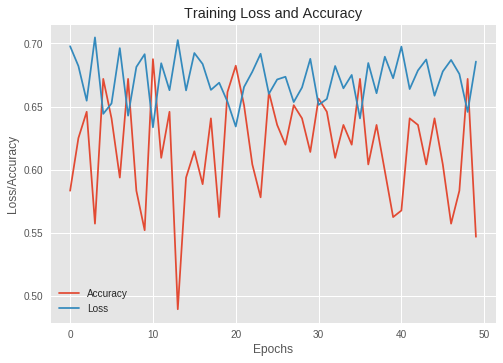

In [0]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/Segmentado/Treino-' + architecture + '.png', bbox_inches='tight')

### Teste

*   [How and When to Use ROC Curves and Precision-Recall Curves for Classification in Python](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)
*   [Classification: ROC and AUC ](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)
*   [sklearn.metrics.roc_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html)
*   [sklearn.metrics.accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score)


In [0]:
y_true, y_predict, prob = ler_images_teste(architecture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [0]:
results[architecture] = [precision_score(y_true, y_predict, average='binary'),
                         roc_auc_score(y_true, prob),
                         accuracy_score(y_true, y_predict)]
print('Test Precision: {:.2f}%, AUC: {:.3f}, Accuracy: {:.2f}%'
      .format(100 * results[architecture][0], 
              results[architecture][1],
              100 * results[architecture][2]))

Test Precision: 0.00%, AUC: 0.401, Accuracy: 80.36%


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


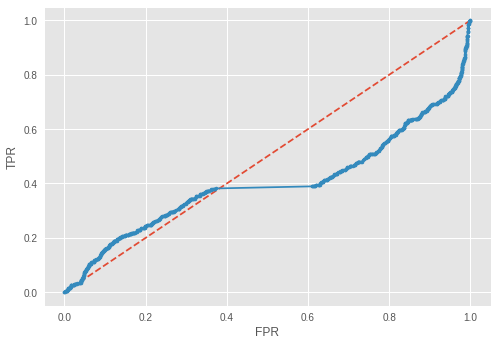

In [0]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_true, prob)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.plot(fpr, tpr, marker='.')
plt.savefig('drive/My Drive/Resultado/Segmentado/Teste-ROC_CURVE-' + architecture + '.png', bbox_inches='tight')

## 2 tentativa  - Test Precision: 0.00%, AUC: 0.695, Accuracy: 80.36%

**Descrição**


*   Modelo descrito no artigo "Crowdsourcing for Chromosome Segmentation and Deep Classification"
*   Alteração nas duas ultimas camadas Dense





In [0]:
architecture = 'architecture_2'

### Modelo

In [0]:
model = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(120, 120, 3)),
    Conv2D(64, (3, 3), activation='relu'),
    Dropout(0.2),
    MaxPooling2D(pool_size=(2, 2)),
   
    Conv2D(32, (3, 3), activation='relu'),
    Conv2D(32, (3, 3), activation='relu'),
    Dropout(0.2),
    MaxPooling2D(pool_size=(2, 2)),
   
    Conv2D(16, (3, 3), activation='relu'),
    Conv2D(16, (3, 3), activation='relu'),
    Dropout(0.2),
    MaxPooling2D(pool_size=(2, 2)),
   
    Conv2D(8, (3, 3), activation='relu'),
    Conv2D(8, (3, 3), activation='relu'),
    Dropout(0.2),
    MaxPooling2D(pool_size=(2, 2)),
    
    Flatten(),
    Dense(512, activation='relu'),
   
    Dense(2, activation='softmax')
]
)

In [0]:
model.compile(SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False), 
              loss='binary_crossentropy', metrics=['accuracy'])

### Treino


In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/Segmentado/weights_' + architecture + '.hdf5', verbose=1, save_best_only=True)

In [0]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 2s - loss: 0.6927 - acc: 0.5677 - val_loss: 0.6898 - val_acc: 0.6406

Epoch 00001: val_loss improved from inf to 0.68978, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_2.hdf5
Epoch 2/50
 - 1s - loss: 0.6889 - acc: 0.6302 - val_loss: 0.6918 - val_acc: 0.5312

Epoch 00002: val_loss did not improve from 0.68978
Epoch 3/50
 - 1s - loss: 0.6866 - acc: 0.6146 - val_loss: 0.6806 - val_acc: 0.6875

Epoch 00003: val_loss improved from 0.68978 to 0.68065, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_2.hdf5
Epoch 4/50
 - 1s - loss: 0.6792 - acc: 0.6615 - val_loss: 0.6819 - val_acc: 0.6250

Epoch 00004: val_loss did not improve from 0.68065
Epoch 5/50
 - 1s - loss: 0.6752 - acc: 0.6615 - val_loss: 0.6729 - val_acc: 0.6719

Epoch 00005: val_loss improved from 0.68065 to 0.67292, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_2.hdf5
Epoch 6/50
 - 1s - loss: 0.6704 - acc: 0.6667 - val_loss: 0.6667 - val_acc

In [0]:
model.load_weights('drive/My Drive/Resultado/Segmentado/weights_' + architecture + '.hdf5')

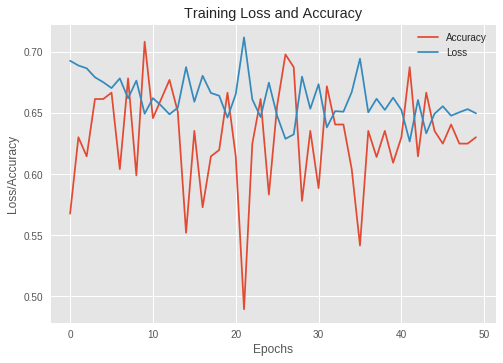

In [0]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/Segmentado/Treino-' + architecture + '.png', bbox_inches='tight')

### Teste

*   [How and When to Use ROC Curves and Precision-Recall Curves for Classification in Python](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)
*   [Classification: ROC and AUC ](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)
*   [sklearn.metrics.roc_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html)
*   [sklearn.metrics.accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score)


In [0]:
y_true, y_predict, prob = ler_images_teste(architecture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [0]:
results[architecture] = [precision_score(y_true, y_predict, average='binary'),
                         roc_auc_score(y_true, prob),
                         accuracy_score(y_true, y_predict)]
print('Test Precision: {:.2f}%, AUC: {:.3f}, Accuracy: {:.2f}%'
      .format(100 * results[architecture][0], 
              results[architecture][1],
              100 * results[architecture][2]))

Test Precision: 0.00%, AUC: 0.695, Accuracy: 80.36%


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


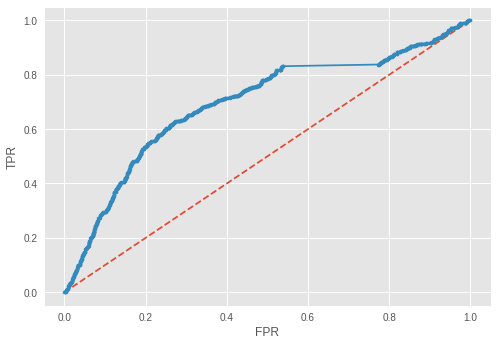

In [0]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_true, prob)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.plot(fpr, tpr, marker='.')
plt.savefig('drive/My Drive/Resultado/Segmentado/Teste-ROC_CURVE-' + architecture + '.png', bbox_inches='tight')

## 3 tentativa - Test Precision: 14.29%, AUC: 0.859, Accuracy: 80.21%

Modelo criado pelo **Lucas Valentim**

https://github.com/lucasvalentim/chromosome-recognizer/blob/master/chromosome_recognizer.ipynb

In [0]:
architecture = 'architecture_3'

### Modelo

In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), 
                 input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (1,1), kernel_regularizer=l2(1e-4)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid', kernel_regularizer=l2(1e-4)))

In [0]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

### Treino


In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/Segmentado/weights_' + architecture + '.hdf5', verbose=1, save_best_only=True)

In [0]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 3s - loss: 2.3042 - acc: 0.5104 - val_loss: 0.6992 - val_acc: 0.7031

Epoch 00001: val_loss improved from inf to 0.69923, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_3.hdf5
Epoch 2/50
 - 1s - loss: 1.5569 - acc: 0.5573 - val_loss: 0.7383 - val_acc: 0.6172

Epoch 00002: val_loss did not improve from 0.69923
Epoch 3/50
 - 1s - loss: 0.9088 - acc: 0.6250 - val_loss: 0.7051 - val_acc: 0.5938

Epoch 00003: val_loss did not improve from 0.69923
Epoch 4/50
 - 1s - loss: 0.6313 - acc: 0.7656 - val_loss: 0.5994 - val_acc: 0.6953

Epoch 00004: val_loss improved from 0.69923 to 0.59937, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_3.hdf5
Epoch 5/50
 - 1s - loss: 0.5520 - acc: 0.7552 - val_loss: 0.5465 - val_acc: 0.7344

Epoch 00005: val_loss improved from 0.59937 to 0.54649, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_3.hdf5
Epoch 6/50
 - 1s - loss: 0.6098 - acc: 0.7135 - val_loss: 0.8365 - val_acc

In [0]:
model.load_weights('drive/My Drive/Resultado/Segmentado/weights_' + architecture + '.hdf5')

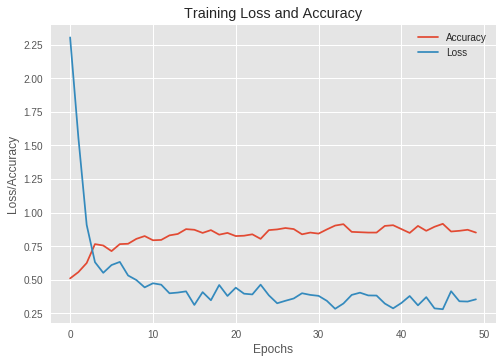

In [0]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/Segmentado/Treino-' + architecture + '.png', bbox_inches='tight')

### Teste

*   [How and When to Use ROC Curves and Precision-Recall Curves for Classification in Python](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)
*   [Classification: ROC and AUC ](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)
*   [sklearn.metrics.roc_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html)
*   [sklearn.metrics.accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score)


In [0]:
y_true, y_predict, prob = ler_images_teste(architecture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [0]:
results[architecture] = [precision_score(y_true, y_predict, average='binary'),
                         roc_auc_score(y_true, prob),
                         accuracy_score(y_true, y_predict)]
print('Test Precision: {:.2f}%, AUC: {:.3f}, Accuracy: {:.2f}%'
      .format(100 * results[architecture][0], 
              results[architecture][1],
              100 * results[architecture][2]))

Test Precision: 14.29%, AUC: 0.859, Accuracy: 80.21%


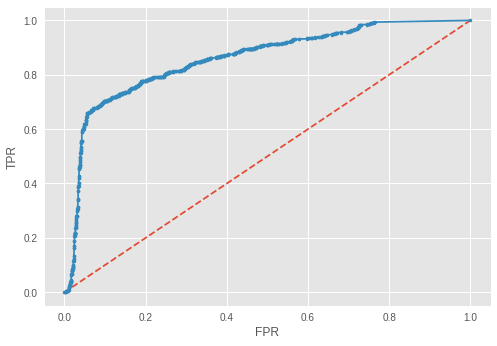

In [0]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_true, prob)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.plot(fpr, tpr, marker='.')
plt.savefig('drive/My Drive/Resultado/Segmentado/Teste-ROC_CURVE-' + architecture + '.png', bbox_inches='tight')

## 4 tentativa - Test Precision: 0.00%, AUC: 0.312, Accuracy: 80.36%

Modelo adaptado do **Lucas Valentim**

*   Sem os **dropout**


In [0]:
architecture = 'architecture_4'

### Modelo

In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), 
                 input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (1,1), kernel_regularizer=l2(1e-4)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Dense(2, activation='sigmoid', kernel_regularizer=l2(1e-4)))

In [0]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

### Treino


In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/Segmentado/weights_' + architecture + '.hdf5', verbose=1, save_best_only=True)

In [0]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 3s - loss: 0.6025 - acc: 0.7370 - val_loss: 2.9011 - val_acc: 0.4297

Epoch 00001: val_loss improved from inf to 2.90107, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_4.hdf5
Epoch 2/50
 - 1s - loss: 0.3994 - acc: 0.8542 - val_loss: 1.7598 - val_acc: 0.5156

Epoch 00002: val_loss improved from 2.90107 to 1.75982, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_4.hdf5
Epoch 3/50
 - 1s - loss: 0.3398 - acc: 0.8724 - val_loss: 0.9166 - val_acc: 0.7432

Epoch 00003: val_loss improved from 1.75982 to 0.91657, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_4.hdf5
Epoch 4/50
 - 1s - loss: 0.4236 - acc: 0.8854 - val_loss: 0.3646 - val_acc: 0.8516

Epoch 00004: val_loss improved from 0.91657 to 0.36459, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_4.hdf5
Epoch 5/50
 - 1s - loss: 0.3801 - acc: 0.8620 - val_loss: 0.4003 - val_acc: 0.8594

Epoch 00005: val_loss did not improve fr

In [0]:
model.load_weights('drive/My Drive/Resultado/Segmentado/weights_' + architecture + '.hdf5')

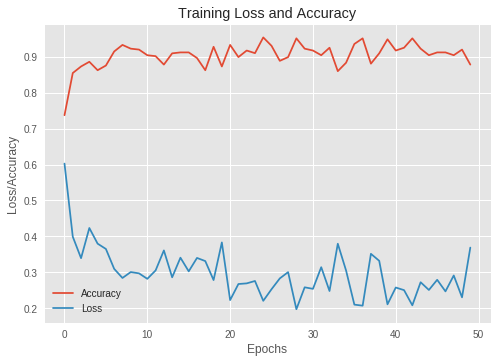

In [0]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/Segmentado/Treino-' + architecture + '.png', bbox_inches='tight')

### Teste

*   [How and When to Use ROC Curves and Precision-Recall Curves for Classification in Python](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)
*   [Classification: ROC and AUC ](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)
*   [sklearn.metrics.roc_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html)
*   [sklearn.metrics.accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score)


In [0]:
y_true, y_predict, prob = ler_images_teste(architecture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [0]:
results[architecture] = [precision_score(y_true, y_predict, average='binary'),
                         roc_auc_score(y_true, prob),
                         accuracy_score(y_true, y_predict)]
print('Test Precision: {:.2f}%, AUC: {:.3f}, Accuracy: {:.2f}%'
      .format(100 * results[architecture][0], 
              results[architecture][1],
              100 * results[architecture][2]))

Test Precision: 0.00%, AUC: 0.312, Accuracy: 80.36%


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


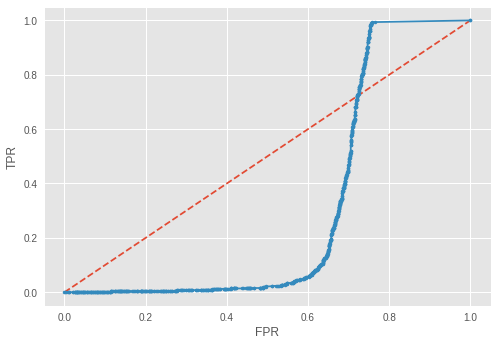

In [0]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_true, prob)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.plot(fpr, tpr, marker='.')
plt.savefig('drive/My Drive/Resultado/Segmentado/Teste-ROC_CURVE-' + architecture + '.png', bbox_inches='tight')

## 5 tentativa - Test Precision: 16.13%, AUC: 0.449, Accuracy: 79.72%

Modelo adaptado do **Lucas Valentim**

*   Sem os **dropout**
*   Função **SGD** para compilação


In [0]:
architecture = 'architecture_5'

### Modelo

In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), 
                 input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (1,1), kernel_regularizer=l2(1e-4)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid', kernel_regularizer=l2(1e-4)))

In [0]:
model.compile(SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False), 
              loss='binary_crossentropy', metrics=['accuracy'])

### Treino


In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/Segmentado/weights_' + architecture + '.hdf5', verbose=1, save_best_only=True)

In [0]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 3s - loss: 2.5951 - acc: 0.5000 - val_loss: 1.2151 - val_acc: 0.3750

Epoch 00001: val_loss improved from inf to 1.21508, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_5.hdf5
Epoch 2/50
 - 1s - loss: 1.4867 - acc: 0.5365 - val_loss: 0.8258 - val_acc: 0.4141

Epoch 00002: val_loss improved from 1.21508 to 0.82581, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_5.hdf5
Epoch 3/50
 - 1s - loss: 1.2500 - acc: 0.5703 - val_loss: 0.6846 - val_acc: 0.6328

Epoch 00003: val_loss improved from 0.82581 to 0.68456, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_5.hdf5
Epoch 4/50
 - 1s - loss: 0.8860 - acc: 0.6474 - val_loss: 0.6350 - val_acc: 0.6719

Epoch 00004: val_loss improved from 0.68456 to 0.63496, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_5.hdf5
Epoch 5/50
 - 1s - loss: 0.9131 - acc: 0.6510 - val_loss: 0.6223 - val_acc: 0.6484

Epoch 00005: val_loss improved from 0.63

In [0]:
model.load_weights('drive/My Drive/Resultado/Segmentado/weights_' + architecture + '.hdf5')

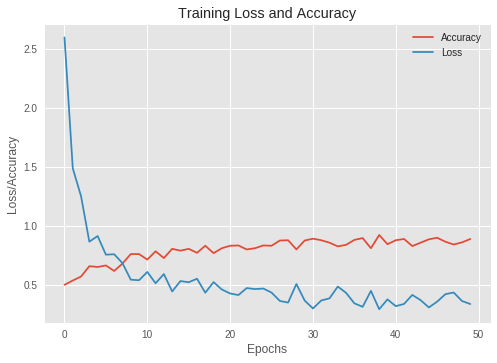

In [0]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/Segmentado/Treino-' + architecture + '.png', bbox_inches='tight')

### Teste

*   [How and When to Use ROC Curves and Precision-Recall Curves for Classification in Python](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)
*   [Classification: ROC and AUC ](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)
*   [sklearn.metrics.roc_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html)
*   [sklearn.metrics.accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score)


In [0]:
y_true, y_predict, prob = ler_images_teste(architecture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [0]:
results[architecture] = [precision_score(y_true, y_predict, average='binary'),
                         roc_auc_score(y_true, prob),
                         accuracy_score(y_true, y_predict)]
print('Test Precision: {:.2f}%, AUC: {:.3f}, Accuracy: {:.2f}%'
      .format(100 * results[architecture][0], 
              results[architecture][1],
              100 * results[architecture][2]))

Test Precision: 16.13%, AUC: 0.449, Accuracy: 79.72%


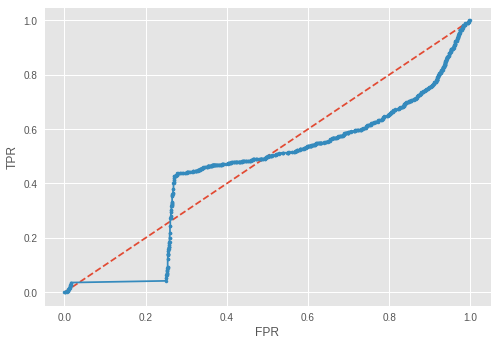

In [0]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_true, prob)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.plot(fpr, tpr, marker='.')
plt.savefig('drive/My Drive/Resultado/Segmentado/Teste-ROC_CURVE-' + architecture + '.png', bbox_inches='tight')

## 6 tentativa - Test Precision: 0.00%, AUC: 0.939, Accuracy: 80.36%

Modelo adaptado do **Lucas Valentim**

*   Sem os **dropout**
*   Função **SGD** para compilação
*   **BatchNormalization** antes da ultima camada Dense


In [0]:
architecture = 'architecture_6'

### Modelo

In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), 
                 input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (1,1), kernel_regularizer=l2(1e-4)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Dense(2, activation='sigmoid', kernel_regularizer=l2(1e-4)))

In [0]:
model.compile(SGD(lr=0.03, momentum=0.0, decay=0.0, nesterov=False), 
              loss='binary_crossentropy', metrics=['accuracy'])

### Treino


In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/Segmentado/weights_' + architecture + '.hdf5', verbose=1, save_best_only=True)

In [0]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 3s - loss: 0.6372 - acc: 0.6693 - val_loss: 2.1003 - val_acc: 0.5469

Epoch 00001: val_loss improved from inf to 2.10026, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_6.hdf5
Epoch 2/50
 - 1s - loss: 0.4133 - acc: 0.8594 - val_loss: 0.7807 - val_acc: 0.7109

Epoch 00002: val_loss improved from 2.10026 to 0.78071, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_6.hdf5
Epoch 3/50
 - 1s - loss: 0.4046 - acc: 0.8568 - val_loss: 0.7381 - val_acc: 0.6719

Epoch 00003: val_loss improved from 0.78071 to 0.73810, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_6.hdf5
Epoch 4/50
 - 1s - loss: 0.4763 - acc: 0.8333 - val_loss: 0.5165 - val_acc: 0.8047

Epoch 00004: val_loss improved from 0.73810 to 0.51646, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_6.hdf5
Epoch 5/50
 - 1s - loss: 0.3592 - acc: 0.8828 - val_loss: 0.6720 - val_acc: 0.6875

Epoch 00005: val_loss did not improve fr

In [0]:
model.load_weights('drive/My Drive/Resultado/Segmentado/weights_' + architecture + '.hdf5')

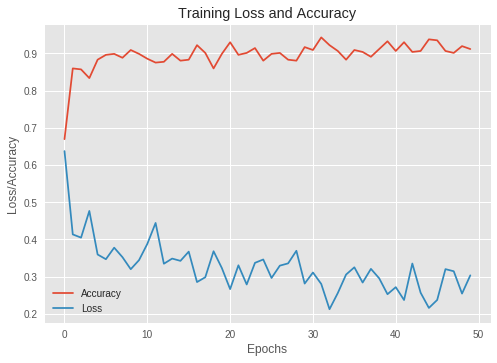

In [0]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/Segmentado/Treino-' + architecture + '.png', bbox_inches='tight')

### Teste

*   [How and When to Use ROC Curves and Precision-Recall Curves for Classification in Python](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)
*   [Classification: ROC and AUC ](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)
*   [sklearn.metrics.roc_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html)
*   [sklearn.metrics.accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score)


In [0]:
y_true, y_predict, prob = ler_images_teste(architecture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [0]:
results[architecture] = [precision_score(y_true, y_predict, average='binary'),
                         roc_auc_score(y_true, prob),
                         accuracy_score(y_true, y_predict)]
print('Test Precision: {:.2f}%, AUC: {:.3f}, Accuracy: {:.2f}%'
      .format(100 * results[architecture][0], 
              results[architecture][1],
              100 * results[architecture][2]))

Test Precision: 0.00%, AUC: 0.939, Accuracy: 80.36%


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


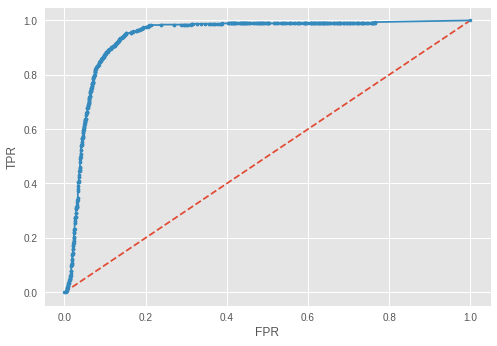

In [0]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_true, prob)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.plot(fpr, tpr, marker='.')
plt.savefig('drive/My Drive/Resultado/Segmentado/Teste-ROC_CURVE-' + architecture + '.png', bbox_inches='tight')

## 7 tentativa - Test Precision: 0.33%, AUC: 0.292, Accuracy: 44.11%

Modelo adaptado do **Lucas Valentim**

*   Sem os **dropout**
*   Função **Adadelta** para compilação
*   **BatchNormalization** antes da ultima camada Dense


In [0]:
architecture = 'architecture_7'

### Modelo

In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2
from keras.optimizers import Adadelta

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), 
                 input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (1,1), kernel_regularizer=l2(1e-4)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Dense(2, activation='sigmoid', kernel_regularizer=l2(1e-4)))

In [0]:
model.compile(Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0), 
              loss='binary_crossentropy', metrics=['accuracy'])

### Treino


In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/Segmentado/weights_' + architecture + '.hdf5', verbose=1, save_best_only=True)

In [0]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 4s - loss: 0.4879 - acc: 0.7734 - val_loss: 0.7862 - val_acc: 0.7031

Epoch 00001: val_loss improved from inf to 0.78618, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_7.hdf5
Epoch 2/50
 - 1s - loss: 0.4847 - acc: 0.8333 - val_loss: 0.5226 - val_acc: 0.7891

Epoch 00002: val_loss improved from 0.78618 to 0.52262, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_7.hdf5
Epoch 3/50
 - 1s - loss: 0.3851 - acc: 0.8724 - val_loss: 1.0981 - val_acc: 0.7109

Epoch 00003: val_loss did not improve from 0.52262
Epoch 4/50
 - 1s - loss: 0.3733 - acc: 0.8776 - val_loss: 1.6988 - val_acc: 0.3984

Epoch 00004: val_loss did not improve from 0.52262
Epoch 5/50
 - 1s - loss: 0.3702 - acc: 0.8802 - val_loss: 0.5831 - val_acc: 0.7973

Epoch 00005: val_loss did not improve from 0.52262
Epoch 6/50
 - 1s - loss: 0.3344 - acc: 0.9193 - val_loss: 0.9515 - val_acc: 0.7812

Epoch 00006: val_loss did not improve from 0.52262
Epoch 7/50
 - 1s - loss:

In [0]:
model.load_weights('drive/My Drive/Resultado/Segmentado/weights_' + architecture + '.hdf5')

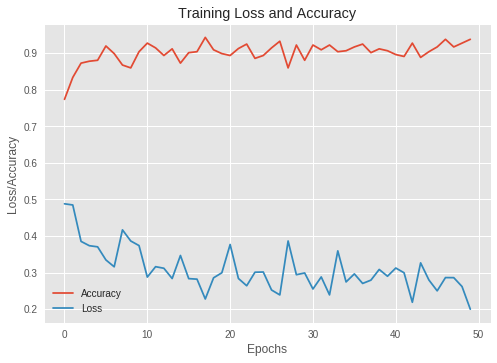

In [0]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/Segmentado/Treino-' + architecture + '.png', bbox_inches='tight')

### Teste

*   [How and When to Use ROC Curves and Precision-Recall Curves for Classification in Python](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)
*   [Classification: ROC and AUC ](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)
*   [sklearn.metrics.roc_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html)
*   [sklearn.metrics.accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score)


In [0]:
y_true, y_predict, prob = ler_images_teste(architecture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [0]:
results[architecture] = [precision_score(y_true, y_predict, average='binary'),
                         roc_auc_score(y_true, prob),
                         accuracy_score(y_true, y_predict)]
print('Test Precision: {:.2f}%, AUC: {:.3f}, Accuracy: {:.2f}%'
      .format(100 * results[architecture][0], 
              results[architecture][1],
              100 * results[architecture][2]))

Test Precision: 0.33%, AUC: 0.292, Accuracy: 44.11%


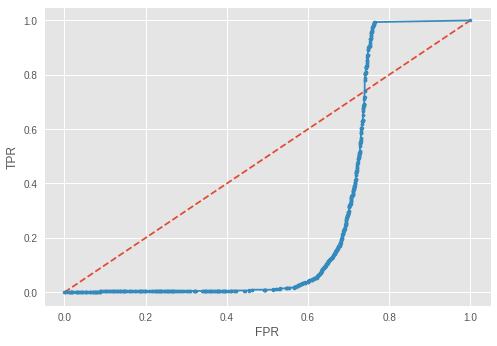

In [0]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_true, prob)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.plot(fpr, tpr, marker='.')
plt.savefig('drive/My Drive/Resultado/Segmentado/Teste-ROC_CURVE-' + architecture + '.png', bbox_inches='tight')

## 8 tentativa - Test Precision: 33.33%, AUC: 0.768, Accuracy: 79.81%

Modelo adaptado do **Lucas Valentim**

*   Função **Adadelta** para compilação


In [0]:
architecture = 'architecture_8'

### Modelo

In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2
from keras.optimizers import Adadelta

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), 
                 input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (1,1), kernel_regularizer=l2(1e-4)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid', kernel_regularizer=l2(1e-4)))

In [0]:
model.compile(Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0), 
              loss='binary_crossentropy', metrics=['accuracy'])

### Treino


In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/Segmentado/weights_' + architecture + '.hdf5', verbose=1, save_best_only=True)

In [0]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 4s - loss: 2.4510 - acc: 0.5275 - val_loss: 0.7560 - val_acc: 0.6094

Epoch 00001: val_loss improved from inf to 0.75599, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_8.hdf5
Epoch 2/50
 - 1s - loss: 1.1199 - acc: 0.6380 - val_loss: 1.0710 - val_acc: 0.4141

Epoch 00002: val_loss did not improve from 0.75599
Epoch 3/50
 - 1s - loss: 1.3128 - acc: 0.6146 - val_loss: 0.6241 - val_acc: 0.6328

Epoch 00003: val_loss improved from 0.75599 to 0.62413, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_8.hdf5
Epoch 4/50
 - 1s - loss: 0.9346 - acc: 0.6484 - val_loss: 0.5238 - val_acc: 0.7109

Epoch 00004: val_loss improved from 0.62413 to 0.52378, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_8.hdf5
Epoch 5/50
 - 1s - loss: 0.6886 - acc: 0.6953 - val_loss: 0.9719 - val_acc: 0.5000

Epoch 00005: val_loss did not improve from 0.52378
Epoch 6/50
 - 1s - loss: 0.7327 - acc: 0.7214 - val_loss: 0.4962 - val_acc

In [0]:
model.load_weights('drive/My Drive/Resultado/Segmentado/weights_' + architecture + '.hdf5')

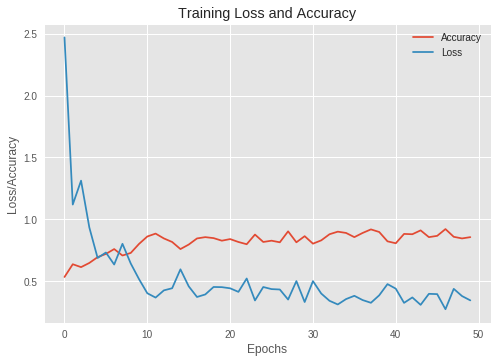

In [0]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/Segmentado/Treino-' + architecture + '.png', bbox_inches='tight')

### Teste

*   [How and When to Use ROC Curves and Precision-Recall Curves for Classification in Python](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)
*   [Classification: ROC and AUC ](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)
*   [sklearn.metrics.roc_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html)
*   [sklearn.metrics.accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score)


In [0]:
y_true, y_predict, prob = ler_images_teste(architecture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [0]:
results[architecture] = [precision_score(y_true, y_predict, average='binary'),
                         roc_auc_score(y_true, prob),
                         accuracy_score(y_true, y_predict)]
print('Test Precision: {:.2f}%, AUC: {:.3f}, Accuracy: {:.2f}%'
      .format(100 * results[architecture][0], 
              results[architecture][1],
              100 * results[architecture][2]))

Test Precision: 33.33%, AUC: 0.768, Accuracy: 79.81%


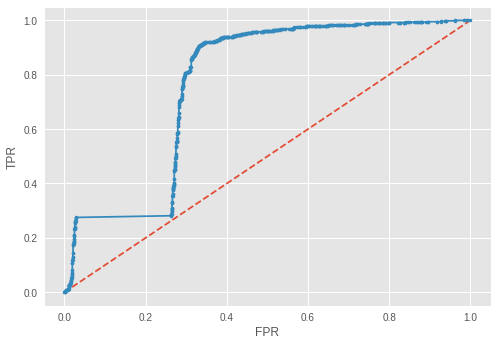

In [0]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_true, prob)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.plot(fpr, tpr, marker='.')
plt.savefig('drive/My Drive/Resultado/Segmentado/Teste-ROC_CURVE-' + architecture + '.png', bbox_inches='tight')

## 9 tentativa - Test Precision: 32.14%, AUC: 0.748, Accuracy: 79.75%

Modelo adaptado do**Lucas Valentim**

*   Função **SGD** para compilação


In [0]:
architecture = 'architecture_9'

### Modelo

In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), 
                 input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (1,1), kernel_regularizer=l2(1e-4)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid', kernel_regularizer=l2(1e-4)))

In [0]:
model.compile(SGD(lr=0.03, momentum=0.0, decay=0.0, nesterov=False), 
              loss='binary_crossentropy', metrics=['accuracy'])

### Treino


In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/Segmentado/weights_' + architecture + '.hdf5', verbose=1, save_best_only=True)

In [0]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 4s - loss: 6.6682 - acc: 0.4714 - val_loss: 7.3888 - val_acc: 0.5156

Epoch 00001: val_loss improved from inf to 7.38879, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_9.hdf5
Epoch 2/50
 - 1s - loss: 6.7096 - acc: 0.5365 - val_loss: 4.3279 - val_acc: 0.6406

Epoch 00002: val_loss improved from 7.38879 to 4.32787, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_9.hdf5
Epoch 3/50
 - 1s - loss: 2.4109 - acc: 0.5964 - val_loss: 1.4226 - val_acc: 0.5234

Epoch 00003: val_loss improved from 4.32787 to 1.42264, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_9.hdf5
Epoch 4/50
 - 1s - loss: 1.4155 - acc: 0.5365 - val_loss: 0.7272 - val_acc: 0.6562

Epoch 00004: val_loss improved from 1.42264 to 0.72722, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_9.hdf5
Epoch 5/50
 - 1s - loss: 0.7157 - acc: 0.6510 - val_loss: 0.6746 - val_acc: 0.6250

Epoch 00005: val_loss improved from 0.72

In [0]:
model.load_weights('drive/My Drive/Resultado/Segmentado/weights_' + architecture + '.hdf5')

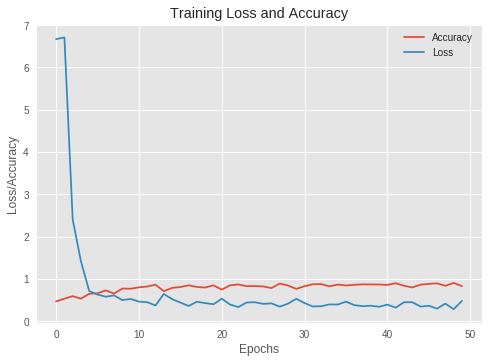

In [0]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/Segmentado/Treino-' + architecture + '.png', bbox_inches='tight')

### Teste

*   [How and When to Use ROC Curves and Precision-Recall Curves for Classification in Python](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)
*   [Classification: ROC and AUC ](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)
*   [sklearn.metrics.roc_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html)
*   [sklearn.metrics.accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score)


In [0]:
y_true, y_predict, prob = ler_images_teste(architecture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [0]:
results[architecture] = [precision_score(y_true, y_predict, average='binary'),
                         roc_auc_score(y_true, prob),
                         accuracy_score(y_true, y_predict)]
print('Test Precision: {:.2f}%, AUC: {:.3f}, Accuracy: {:.2f}%'
      .format(100 * results[architecture][0], 
              results[architecture][1],
              100 * results[architecture][2]))

Test Precision: 32.14%, AUC: 0.748, Accuracy: 79.75%


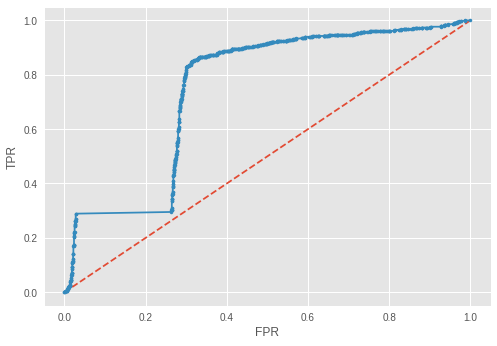

In [0]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_true, prob)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.plot(fpr, tpr, marker='.')
plt.savefig('drive/My Drive/Resultado/Segmentado/Teste-ROC_CURVE-' + architecture + '.png', bbox_inches='tight')

## 10 tentativa - Test Precision: 0.00%, AUC: 0.662, Accuracy: 80.36%

Modelo adaptado do **Lucas Valentim**

*   Função **adam** para compilação
*   Adicionado mais 2 camadas convolutivas

In [0]:
architecture = 'architecture_10'

### Modelo

In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), 
                 input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(96, (3, 3),activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(96, (3, 3),activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (1,1), kernel_regularizer=l2(1e-4)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid', kernel_regularizer=l2(1e-4)))

In [0]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

### Treino


In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/Segmentado/weights_' + architecture + '.hdf5', verbose=1, save_best_only=True)

In [0]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 5s - loss: 1.4630 - acc: 0.5990 - val_loss: 0.8035 - val_acc: 0.5547

Epoch 00001: val_loss improved from inf to 0.80351, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_10.hdf5
Epoch 2/50
 - 1s - loss: 1.1783 - acc: 0.6172 - val_loss: 1.0361 - val_acc: 0.4844

Epoch 00002: val_loss did not improve from 0.80351
Epoch 3/50
 - 1s - loss: 0.9993 - acc: 0.6224 - val_loss: 0.6406 - val_acc: 0.7344

Epoch 00003: val_loss improved from 0.80351 to 0.64064, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_10.hdf5
Epoch 4/50
 - 1s - loss: 0.9193 - acc: 0.6589 - val_loss: 1.2285 - val_acc: 0.3984

Epoch 00004: val_loss did not improve from 0.64064
Epoch 5/50
 - 1s - loss: 0.7069 - acc: 0.6615 - val_loss: 1.0047 - val_acc: 0.5469

Epoch 00005: val_loss did not improve from 0.64064
Epoch 6/50
 - 1s - loss: 0.5661 - acc: 0.7604 - val_loss: 0.5406 - val_acc: 0.7422

Epoch 00006: val_loss improved from 0.64064 to 0.54056, saving model to d

In [0]:
model.load_weights('drive/My Drive/Resultado/Segmentado/weights_' + architecture + '.hdf5')

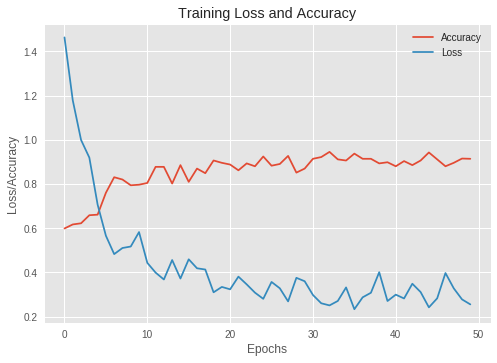

In [0]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/Segmentado/Treino-' + architecture + '.png', bbox_inches='tight')

### Teste

*   [How and When to Use ROC Curves and Precision-Recall Curves for Classification in Python](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)
*   [Classification: ROC and AUC ](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)
*   [sklearn.metrics.roc_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html)
*   [sklearn.metrics.accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score)


In [0]:
y_true, y_predict, prob = ler_images_teste(architecture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [0]:
results[architecture] = [precision_score(y_true, y_predict, average='binary'),
                         roc_auc_score(y_true, prob),
                         accuracy_score(y_true, y_predict)]
print('Test Precision: {:.2f}%, AUC: {:.3f}, Accuracy: {:.2f}%'
      .format(100 * results[architecture][0], 
              results[architecture][1],
              100 * results[architecture][2]))

Test Precision: 0.00%, AUC: 0.662, Accuracy: 80.36%


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


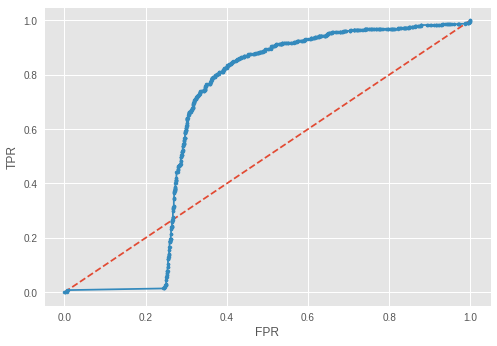

In [0]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_true, prob)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.plot(fpr, tpr, marker='.')
plt.savefig('drive/My Drive/Resultado/Segmentado/Teste-ROC_CURVE-' + architecture + '.png', bbox_inches='tight')

## 11 tentativa - Test Precision: 0.64%, AUC: 0.359, Accuracy: 61.60%

Modelo adaptado do **Lucas Valentim**

*   Função **SGD** para compilação
*   Adicionado mais 2 camadas convolutivas

In [0]:
architecture = 'architecture_11'

### Modelo

In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4), 
                 input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(96, (3, 3),activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(Conv2D(96, (3, 3),activation='relu', kernel_regularizer=l2(1e-4)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (1,1), kernel_regularizer=l2(1e-4)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu', kernel_regularizer=l2(1e-4)))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid', kernel_regularizer=l2(1e-4)))

In [0]:
model.compile(SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False), 
              loss='binary_crossentropy', metrics=['accuracy'])

### Treino


In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/Segmentado/weights_' + architecture + '.hdf5', verbose=1, save_best_only=True)

In [0]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 5s - loss: 2.3236 - acc: 0.5078 - val_loss: 0.9643 - val_acc: 0.3750

Epoch 00001: val_loss improved from inf to 0.96426, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_11.hdf5
Epoch 2/50
 - 1s - loss: 1.1255 - acc: 0.5625 - val_loss: 0.7243 - val_acc: 0.5781

Epoch 00002: val_loss improved from 0.96426 to 0.72428, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_11.hdf5
Epoch 3/50
 - 1s - loss: 1.0099 - acc: 0.5833 - val_loss: 0.8085 - val_acc: 0.5469

Epoch 00003: val_loss did not improve from 0.72428
Epoch 4/50
 - 1s - loss: 0.8972 - acc: 0.6198 - val_loss: 0.8708 - val_acc: 0.4844

Epoch 00004: val_loss did not improve from 0.72428
Epoch 5/50
 - 1s - loss: 0.9592 - acc: 0.5807 - val_loss: 1.0899 - val_acc: 0.3516

Epoch 00005: val_loss did not improve from 0.72428
Epoch 6/50
 - 1s - loss: 0.8198 - acc: 0.6432 - val_loss: 1.1349 - val_acc: 0.4062

Epoch 00006: val_loss did not improve from 0.72428
Epoch 7/50
 - 1s - los

In [0]:
model.load_weights('drive/My Drive/Resultado/Segmentado/weights_' + architecture + '.hdf5')

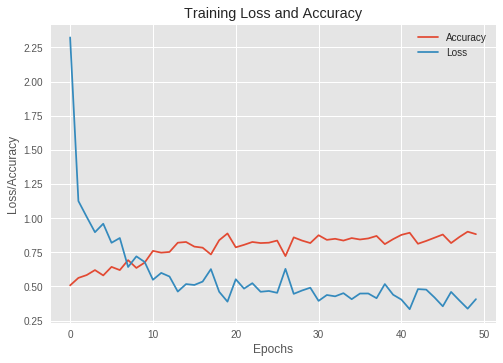

In [0]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/Segmentado/Treino-' + architecture + '.png', bbox_inches='tight')

### Teste

*   [How and When to Use ROC Curves and Precision-Recall Curves for Classification in Python](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)
*   [Classification: ROC and AUC ](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)
*   [sklearn.metrics.roc_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html)
*   [sklearn.metrics.accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score)


In [0]:
y_true, y_predict, prob = ler_images_teste(architecture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [0]:
results[architecture] = [precision_score(y_true, y_predict, average='binary'),
                         roc_auc_score(y_true, prob),
                         accuracy_score(y_true, y_predict)]
print('Test Precision: {:.2f}%, AUC: {:.3f}, Accuracy: {:.2f}%'
      .format(100 * results[architecture][0], 
              results[architecture][1],
              100 * results[architecture][2]))

Test Precision: 0.64%, AUC: 0.359, Accuracy: 61.60%


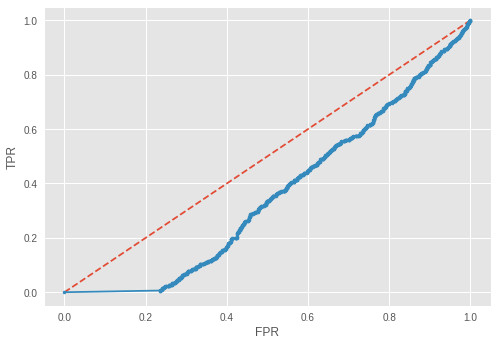

In [0]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_true, prob)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.plot(fpr, tpr, marker='.')
plt.savefig('drive/My Drive/Resultado/Segmentado/Teste-ROC_CURVE-' + architecture + '.png', bbox_inches='tight')

## 12 tentativa - Test Precision: 0.00%, AUC: 0.799, Accuracy: 80.33%

Modelo adaptado do **Lucas Valentim**

*   Sem utilização das funções de regularização
*   Função **SGD** para compilação
*   Adicionado mais 2 camadas convolutivas

In [0]:
architecture = 'architecture_12'

### Modelo

In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu',input_shape=(None, None, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(96, (3, 3),activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(96, (3, 3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (1,1)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid'))

In [0]:
model.compile(SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False), 
              loss='binary_crossentropy', metrics=['accuracy'])

### Treino


In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/Segmentado/weights_' + architecture + '.hdf5', verbose=1, save_best_only=True)

In [0]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 5s - loss: 1.8711 - acc: 0.5469 - val_loss: 0.7623 - val_acc: 0.5391

Epoch 00001: val_loss improved from inf to 0.76234, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_12.hdf5
Epoch 2/50
 - 1s - loss: 1.4693 - acc: 0.5521 - val_loss: 0.6440 - val_acc: 0.6406

Epoch 00002: val_loss improved from 0.76234 to 0.64401, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_12.hdf5
Epoch 3/50
 - 1s - loss: 1.3407 - acc: 0.5286 - val_loss: 0.6003 - val_acc: 0.6875

Epoch 00003: val_loss improved from 0.64401 to 0.60031, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_12.hdf5
Epoch 4/50
 - 1s - loss: 0.8674 - acc: 0.5992 - val_loss: 0.5583 - val_acc: 0.7656

Epoch 00004: val_loss improved from 0.60031 to 0.55835, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_12.hdf5
Epoch 5/50
 - 1s - loss: 0.7152 - acc: 0.6380 - val_loss: 0.5619 - val_acc: 0.6406

Epoch 00005: val_loss did not improv

In [0]:
model.load_weights('drive/My Drive/Resultado/Segmentado/weights_' + architecture + '.hdf5')

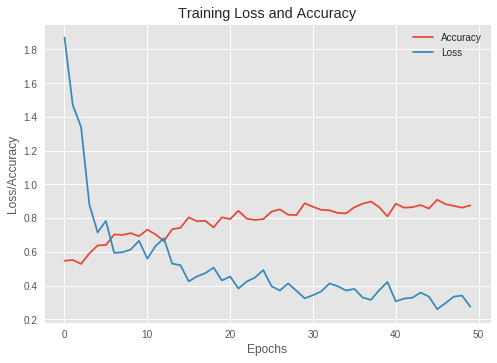

In [0]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/Segmentado/Treino-' + architecture + '.png', bbox_inches='tight')

### Teste

*   [How and When to Use ROC Curves and Precision-Recall Curves for Classification in Python](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)
*   [Classification: ROC and AUC ](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)
*   [sklearn.metrics.roc_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html)
*   [sklearn.metrics.accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score)


In [0]:
y_true, y_predict, prob = ler_images_teste(architecture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [0]:
results[architecture] = [precision_score(y_true, y_predict, average='binary'),
                         roc_auc_score(y_true, prob),
                         accuracy_score(y_true, y_predict)]
print('Test Precision: {:.2f}%, AUC: {:.3f}, Accuracy: {:.2f}%'
      .format(100 * results[architecture][0], 
              results[architecture][1],
              100 * results[architecture][2]))

Test Precision: 0.00%, AUC: 0.799, Accuracy: 80.33%


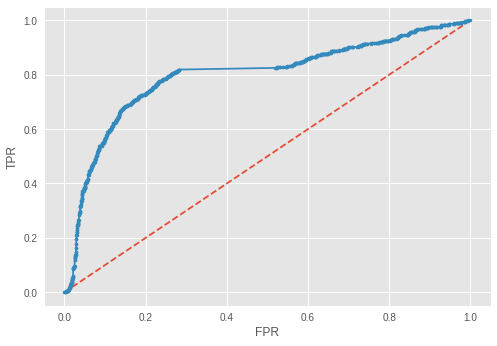

In [0]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_true, prob)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.plot(fpr, tpr, marker='.')
plt.savefig('drive/My Drive/Resultado/Segmentado/Teste-ROC_CURVE-' + architecture + '.png', bbox_inches='tight')

## 13 tentativa - Test Precision: 0.00%, AUC: 0.752, Accuracy: 80.33%

Modelo adaptado do **Lucas Valentim**

*   Utilizado outra função de normalização, diferente da utilizada por ele.

In [0]:
architecture = 'architecture_13'

### Modelo

In [0]:
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.regularizers import l2

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu',input_shape=(None, None, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(64, (5, 5), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(128, (7, 7),activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(128, (1,1)))
model.add(GlobalMaxPooling2D())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid'))

In [0]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

### Treino


In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/Segmentado/weights_' + architecture + '.hdf5', verbose=1, save_best_only=True)

In [0]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Epoch 1/50
 - 5s - loss: 1.2115 - acc: 0.5677 - val_loss: 0.8705 - val_acc: 0.5156

Epoch 00001: val_loss improved from inf to 0.87051, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_13.hdf5
Epoch 2/50
 - 0s - loss: 0.7222 - acc: 0.6484 - val_loss: 0.4488 - val_acc: 0.8281

Epoch 00002: val_loss improved from 0.87051 to 0.44882, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_13.hdf5
Epoch 3/50
 - 0s - loss: 0.7980 - acc: 0.6042 - val_loss: 0.5072 - val_acc: 0.6797

Epoch 00003: val_loss did not improve from 0.44882
Epoch 4/50
 - 0s - loss: 0.6400 - acc: 0.7031 - val_loss: 0.4318 - val_acc: 0.8359

Epoch 00004: val_loss improved from 0.44882 to 0.43182, saving model to drive/My Drive/Resultado/Segmentado/weights_architecture_13.hdf5
Epoch 5/50
 - 1s - loss: 0.7014 - acc: 0.6406 - val_loss: 0.4045 - val_acc: 0.8672

Epoch 00005: val_loss improved from 0.43182 to 0.40453, saving model to drive/My Drive/Resultado/Segmentado/weights_archit

In [0]:
model.load_weights('drive/My Drive/Resultado/Segmentado/weights_' + architecture + '.hdf5')

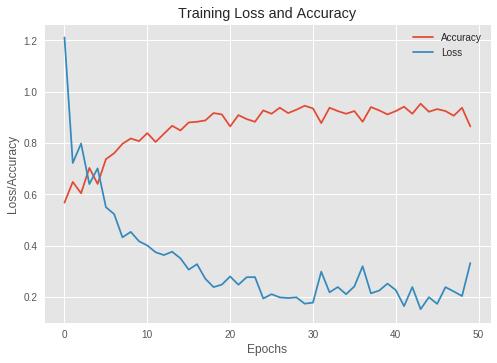

In [0]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/Segmentado/Treino-' + architecture + '.png', bbox_inches='tight')

### Teste

*   [How and When to Use ROC Curves and Precision-Recall Curves for Classification in Python](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)
*   [Classification: ROC and AUC ](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)
*   [sklearn.metrics.roc_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html)
*   [sklearn.metrics.accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score)


In [0]:
y_true, y_predict, prob = ler_images_teste(architecture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [0]:
results[architecture] = [precision_score(y_true, y_predict, average='binary'),
                         roc_auc_score(y_true, prob),
                         accuracy_score(y_true, y_predict)]
print('Test Precision: {:.2f}%, AUC: {:.3f}, Accuracy: {:.2f}%'
      .format(100 * results[architecture][0], 
              results[architecture][1],
              100 * results[architecture][2]))

Test Precision: 0.00%, AUC: 0.752, Accuracy: 80.33%


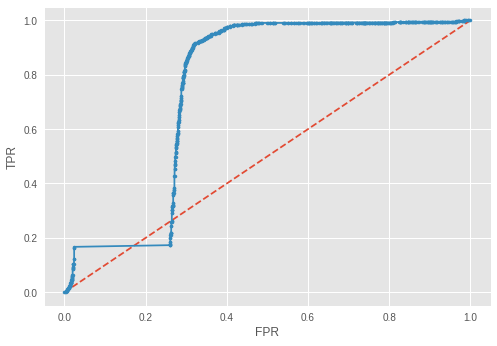

In [0]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_true, prob)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.plot(fpr, tpr, marker='.')
plt.savefig('drive/My Drive/Resultado/Segmentado/Teste-ROC_CURVE-' + architecture + '.png', bbox_inches='tight')

## Mini VGG - Test Precision: 32.63%, AUC: 0.817, Accuracy: 62.36%

In [0]:
architecture = 'miniVGG_base2_binaria'

### Modelo

In [0]:
def build_MiniVGG(width, height, depth, classes):
  # initialize the model
  model = Sequential()
  
  inputShape = (height, width, depth)# first CONV => RELU => CONV => RELU => POOL layer set
  model.add(Conv2D(32, (3, 3), padding="same",
  input_shape=inputShape))
  model.add(Activation("relu"))
  model.add(BatchNormalization(axis=2))
  model.add(Conv2D(32, (3, 3), padding="same"))
  model.add(Activation("relu"))
  model.add(BatchNormalization(axis=2))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))
  
  # second CONV => RELU => CONV => RELU => POOL layer set
  model.add(Conv2D(64, (3, 3), padding="same"))
  model.add(Activation("relu"))
  model.add(BatchNormalization(axis=2))
  model.add(Conv2D(64, (3, 3), padding="same"))
  model.add(Activation("relu"))
  model.add(BatchNormalization(axis=2))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))
  
  # first (and only) set of FC => RELU layers
  model.add(Flatten())
  model.add(Dense(512))
  model.add(Activation("relu"))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  
  # softmax classifier
  model.add(Dense(classes))
  model.add(Activation("softmax"))
  # return the constructed network architecture
  return model

In [15]:
model = build_MiniVGG(width=120, height=120, depth=3, classes=2)

opt = SGD(lr=0.01)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


### Treino

In [0]:
checkpointer = ModelCheckpoint(filepath='drive/My Drive/Resultado/Segmentado/' + 
                               'weights_' + architecture + '.hdf5', verbose=1,
                               save_best_only=True)

In [17]:
training = model.fit_generator(train_batches, steps_per_epoch=stepsPerEpoche, 
                   validation_data=validation_batches, validation_steps=validationSteps,
                   epochs=50, verbose=2, callbacks=[checkpointer])

Instructions for updating:
Use tf.cast instead.
Epoch 1/50
 - 77s - loss: 1.1139 - acc: 0.6510 - val_loss: 1.3873 - val_acc: 0.7344

Epoch 00001: val_loss improved from inf to 1.38728, saving model to drive/My Drive/Resultado/Segmentado/weights_miniVGG_base2_binaria.hdf5
Epoch 2/50
 - 71s - loss: 1.0570 - acc: 0.6927 - val_loss: 0.8408 - val_acc: 0.7031

Epoch 00002: val_loss improved from 1.38728 to 0.84081, saving model to drive/My Drive/Resultado/Segmentado/weights_miniVGG_base2_binaria.hdf5
Epoch 3/50
 - 77s - loss: 0.6097 - acc: 0.8021 - val_loss: 0.7404 - val_acc: 0.7656

Epoch 00003: val_loss improved from 0.84081 to 0.74039, saving model to drive/My Drive/Resultado/Segmentado/weights_miniVGG_base2_binaria.hdf5
Epoch 4/50
 - 68s - loss: 0.5615 - acc: 0.8229 - val_loss: 4.4978 - val_acc: 0.2812

Epoch 00004: val_loss did not improve from 0.74039
Epoch 5/50
 - 71s - loss: 0.3806 - acc: 0.8594 - val_loss: 0.4601 - val_acc: 0.8594

Epoch 00005: val_loss improved from 0.74039 to 0.46

In [0]:
model.load_weights('drive/My Drive/Resultado/Segmentado/weights_' + architecture + '.hdf5')

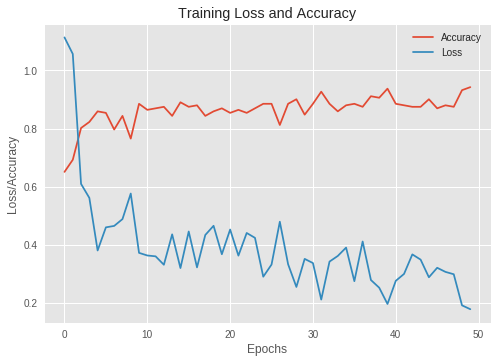

In [19]:
# plotar loss e accuracy para os datasets 'train' e 'test'
plt.style.use("ggplot")
plt.figure()
plt.plot(training.history['acc'], label='Accuracy')
plt.plot(training.history['loss'], label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Training Loss and Accuracy")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.savefig('drive/My Drive/Resultado/Segmentado/Treino-' + architecture + '.png', bbox_inches='tight')

### Teste

*   [How and When to Use ROC Curves and Precision-Recall Curves for Classification in Python](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)
*   [Classification: ROC and AUC ](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)
*   [sklearn.metrics.roc_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html)
*   [sklearn.metrics.accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score)


In [21]:
y_true, y_predict, prob = ler_images_teste(architecture)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


In [22]:
results[architecture] = [precision_score(y_true, y_predict, average='binary'),
                         roc_auc_score(y_true, prob),
                         accuracy_score(y_true, y_predict)]
print('Test Precision: {:.2f}%, AUC: {:.3f}, Accuracy: {:.2f}%'
      .format(100 * results[architecture][0], 
              results[architecture][1],
              100 * results[architecture][2]))

Test Precision: 32.63%, AUC: 0.817, Accuracy: 62.36%


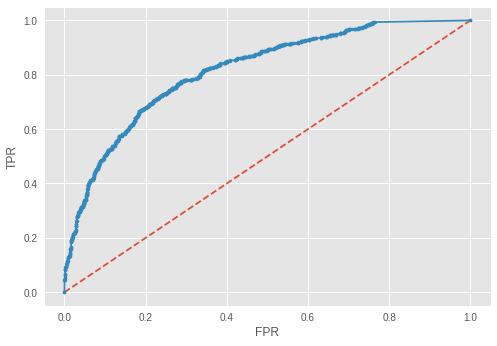

In [23]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_true, prob)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.plot(fpr, tpr, marker='.')
plt.savefig('drive/My Drive/Resultado/Segmentado/Teste-ROC_CURVE-' + architecture + '.png', bbox_inches='tight')